In [2]:
# Imports

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import gnnx

from kgcnn.utils.adj import precompute_adjacency_scaled, scaled_adjacency_to_list
from kgcnn.literature.GCN import getmodelGCN

## Load the Dataset (Mutagenicity)

In [3]:
from dataloader import load_mutagenicity
mutag_graphs, mutag_labels = load_mutagenicity('./data', filter_invalid_molecules=True)

Preprocessing of the graphs & splitting in training and validation set:

In [4]:
def get_tensor_representation(graphs):
    node_features = []
    node_lengths = []
    edge_weights = []
    edge_lengths = []
    edge_indices = []
    for graph in graphs:
        adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(graph)
        edge_information = scaled_adjacency_to_list(precompute_adjacency_scaled(adjacency_matrix))
        edge_indices.append(edge_information[0])
        edge_weights.append(edge_information[1])
        edge_lengths.append(len(edge_information[0]))
        node_information = np.array([graph.nodes[n]['features'] for n in graph.nodes])
        node_features.append(node_information)
        node_lengths.append(len(node_information))
    node_features = np.vstack(node_features)
    node_features_ragged = tf.RaggedTensor.from_row_lengths(node_features, np.array(node_lengths, dtype=np.int))
    edge_weights = np.expand_dims(np.hstack(edge_weights), axis=-1).astype(np.float32)
    edge_weights_ragged =tf.RaggedTensor.from_row_lengths(edge_weights, np.array(edge_lengths, dtype=np.int))
    edge_indices = np.vstack(edge_indices)
    edge_indices_ragged =tf.RaggedTensor.from_row_lengths(edge_indices, np.array(edge_lengths, dtype=np.int))
    return [node_features_ragged, edge_weights_ragged, edge_indices_ragged]

In [5]:
x_train, val_graphs, y_train, y_val = train_test_split(mutag_graphs, mutag_labels, train_size=0.8, random_state=1)
x_train = get_tensor_representation(x_train)
x_val = get_tensor_representation(val_graphs)
y_train = np.expand_dims(np.array(y_train), axis=-1)
y_val = np.expand_dims(np.array(y_val), axis=-1)

## Training of GNN

/pfs/work7/workspace/scratch/upnub-gnnx-0/conda/envs/gnnx2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


26/26 [==============================] - 0s 15ms/step - loss: 0.6062 - accuracy: 0.6980
Epoch 2/2
26/26 [==============================] - 0s 15ms/step - loss: 0.5716 - accuracy: 0.7042
Epoch 3/3
26/26 [==============================] - 0s 15ms/step - loss: 0.5509 - accuracy: 0.7376
Epoch 4/4
26/26 [==============================] - 0s 14ms/step - loss: 0.5432 - accuracy: 0.7450
Epoch 5/5
26/26 [==============================] - 0s 14ms/step - loss: 0.5338 - accuracy: 0.7537
Epoch 6/6
26/26 [==============================] - 0s 15ms/step - loss: 0.5330 - accuracy: 0.7290
Epoch 7/7
26/26 [==============================] - 0s 15ms/step - loss: 0.5169 - accuracy: 0.7673
Epoch 8/8
26/26 [==============================] - 0s 15ms/step - loss: 0.5121 - accuracy: 0.7661
Epoch 9/9
26/26 [==============================] - 0s 15ms/step - loss: 0.4968 - accuracy: 0.7698
Epoch 10/10
26/26 [==============================] - 0s 14ms/step - loss: 0.4858 - accuracy: 0.7822


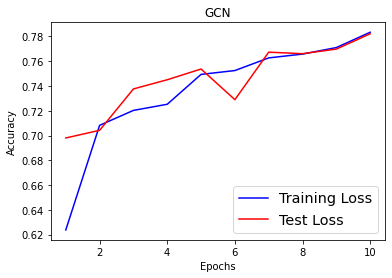

In [6]:
model = getmodelGCN(# Input
                    input_node_shape = [None, 14],
                    input_edge_shape = [None,1],
                    input_state_shape = [1],
                    input_node_vocab = 100,
                    input_edge_vocab = 10,
                    input_state_vocab = 100,
                    input_node_embedd = 64,
                    input_edge_embedd = 64,
                    input_state_embedd = 64,
                    input_type = 'ragged', 
                    # Output
                    output_embedd = 'graph',
                    output_use_bias = [True,True,True,True,True,False],
                    output_dim = [25,25,25,25,10,1],
                    output_activation = ['relu','relu','relu','relu','relu','sigmoid'],
                    output_kernel_regularizer = [None,None,None,None,None,None],
                    output_activity_regularizer = [None,None,None,None,None,None],
                    output_bias_regularizer = [None,None,None,None,None,None],
                    output_type = 'padded',
                    #Model specific
                    depth = 6,
                    hidden_dim = 100, 
                    use_bias = False,
                    activation = 'relu',
                    graph_labeling = True,
                    is_sorted=True,
                    has_unconnected=False)


learning_rate = 1e-4
epo = 10
epostep = 1
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics = ['accuracy'])

trainlossall = []
testlossall = []
validlossall = []

for iepoch in range(0,epo,epostep):

    hist = model.fit(x_train, y_train, 
              epochs=iepoch+epostep,
              initial_epoch=iepoch,
              batch_size=1,
              verbose=1)

    trainlossall.append(hist.history)
    testlossall.append(model.evaluate(x_val, y_val))    

testlossall = np.array(testlossall)
trainlossall = np.concatenate([x['accuracy'] for x in trainlossall])


#Plot loss vs epochs    
plt.figure()
plt.plot(np.arange(1,len(trainlossall)+1),trainlossall,label='Training Loss',c='blue')
plt.plot(np.arange(epostep,epo+epostep,epostep),testlossall[:,1],label='Test Loss',c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GCN')
plt.legend(loc='lower right',fontsize='x-large')
plt.show()

In [9]:
model.evaluate(x_val, y_val)

26/26 [==============================] - 0s 14ms/step - loss: 0.4858 - accuracy: 0.7822


[0.4857757091522217, 0.7821782231330872]

## Implementation of the `gnnx.GNNInterface`

In this case we do not just simply put the mask on the input, but instead use the mask to modify the GNN convolution/message passing operation:

In [20]:
class ExplainableGCN(gnnx.GNNInterface):
    
    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        
        mlp_layer = gnn_model.layers[-1]
        config = mlp_layer.get_config()
        weights = mlp_layer.get_weights()
        cloned_layer = type(mlp_layer).from_config(config)
        pooling_layer = self.PoolingWeightedNodes()
        node_weights = tf.keras.layers.Input(shape=(None,1),name='node_weights',dtype ="float32",ragged=True)
        weighted_pooled = pooling_layer(model.layers[-3].output, node_weights)
        out = cloned_layer(weighted_pooled)
        inputs = model.inputs
        modified_model = tf.keras.Model(inputs=model.inputs + [node_weights], outputs=out)
        cloned_layer.set_weights(weights)
        
        self.gnn_model = modified_model
    
    class PoolingWeightedNodes(tf.keras.layers.Layer):
        """
        Layer for pooling of nodefeatures over all nodes in graph. Which gives $1/n \sum_i node(i)$.

        Args:
            pooling_method : tf.function to pool all nodes compatible with ragged tensors.
            **kwargs
        """

        def __init__(self,
                     pooling_method = "reduce_mean" ,
                     **kwargs):
            """Initialize layer."""
            super(ExplainableGCN.PoolingWeightedNodes, self).__init__(**kwargs)
            self.pooling_method = pooling_method

            if(self.pooling_method == "reduce_mean"):
                self._pool = tf.math.reduce_mean
            elif(self.pooling_method == "reduce_sum"):
                self._pool = tf.math.reduce_sum
            else:
                raise TypeError("Unknown pooling, choose: reduce_mean, reduce_sum, ...")

            self._supports_ragged_inputs = True 
        def build(self, input_shape):
            """Build layer."""
            super(ExplainableGCN.PoolingWeightedNodes, self).build(input_shape)
        def call(self, inputs, weights):
            """Forward pass.

            Args:
                inputs (tf.ragged): Node ragged tensor of shape (batch,None,F)
                weights (tf.ragged): Node weights.

            Returns:
                features (tf.tensor): Pooled node features of shape (batch,F)
            """
            out = self._pool(tf.math.multiply(inputs, weights), axis=1)
            return out
        def get_config(self):
            """Update layer config."""
            config = super(ExplainableGCN.PoolingWeightedNodes, self).get_config()
            config.update({"pooling_method": self.pooling_method})
            return config
    
    
    def predict(self, gnn_input, masking_info=None):
        node_input, edge_input, edge_index_input = gnn_input
        node_weights = tf.expand_dims(tf.ones_like(node_input)[:,:,0], -1)
        return self.gnn_model([node_input, edge_input, edge_index_input, node_weights], training=False)[0]
        
    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input
        
        masked_edge_input = edge_mask * edge_input[0]
        masked_edge_input = tf.RaggedTensor.from_row_splits(masked_edge_input, [0,len(masked_edge_input)])
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32), tf.transpose(feature_mask))
        node_weights = tf.RaggedTensor.from_row_splits(tf.sigmoid(node_mask), [0,len(node_mask)])
        
        masked_pred = self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input, node_weights],
                                     training=training)[0]
        return masked_pred
    
    def get_number_of_nodes(self, gnn_input):
        node_input, _ , _ = gnn_input
        return node_input[0].shape[0]
    
    def get_number_of_node_features(self, gnn_input):
        node_input, _ , _ = gnn_input
        return node_input.shape[2]
    
    def get_number_of_edges(self, gnn_input):
        _ , edge_input, _ = gnn_input
        return edge_input[0].shape[0]
    
    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:,0])
        node_relevance = np.array(node_mask[:,0])
        feature_relevance = np.array(feature_mask[:,0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance
    
    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        element_labels = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0,0,0,relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r,g,b,a = plt.get_cmap('tab20')(element)
            node_color_map.append((r,g,b,graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):  
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2,figsize=(8,12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels),explanation[1], color=bar_colors)
    
    

Instanciate a Explainable GNN:

In [11]:
explainable_gcn = ExplainableGCN(model)

Find the 100 most mutagenic molecules, according to the GNN:

In [12]:
pred = model.predict(x_val)[:,0]
np.argsort(pred)[:100]

array([291, 215, 371, 475, 398, 171,  57, 638, 663, 582, 715, 802, 670,
       421,  26, 270, 754, 123, 105, 299, 585, 228, 153,  33, 702, 735,
       534,  34, 293, 647, 751, 336, 200, 125,  13, 427, 256, 654, 771,
       446, 450, 636, 573,  42, 143, 317, 414, 488, 468,  49, 733, 600,
       471, 666, 399, 423, 593, 550, 787, 747, 237, 155, 234, 213, 668,
       401, 144, 703, 165, 412, 129, 778, 567, 540, 645, 613, 710, 397,
       759, 691, 373, 547, 741, 434, 294, 174, 190, 592, 272, 324,  78,
       245, 621, 411, 181,  28, 566,  91, 740, 179])

Select an instance to explain:

In [13]:
instance_index = 547

Setup an GNNExplainer and explain the instance:

In [14]:
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.1)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.005,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0.0001,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0.0001,
                 'node_mask_norm_ord': 1}

explainer = gnnx.GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

explainer.explain(get_tensor_representation([val_graphs[instance_index]]))
#explainer.explain(get_tensor_representation([val_graphs[instance_index]]), output_to_explain=tf.Variable([0.]))

/pfs/work7/workspace/scratch/upnub-gnnx-0/conda/envs/gnnx2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Let's look at the explanation the GNNExplainer found:

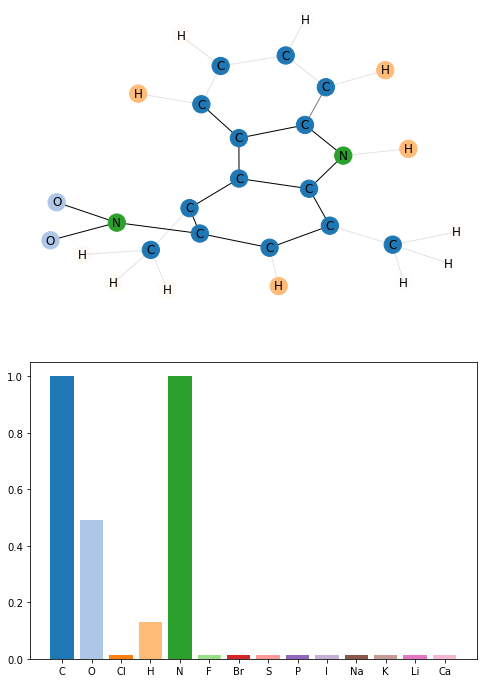

In [15]:
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

If we do not specify the `output_to_explain` as parameter to the `explain` method the Explainer will explain why the GNN came to its conclusion.
For molecules which are classified as non-mutagenic by the GNN, the GNNExplainer will then explain why they are non-mutagenic.

We can also specify `output_to_explain` to be `tf.Variable([0.]`. This way we can tell the Explainer to explain why a molecule could be mutagenic (even for molecules which are classified as most likely non-mutagenic by the GNN):

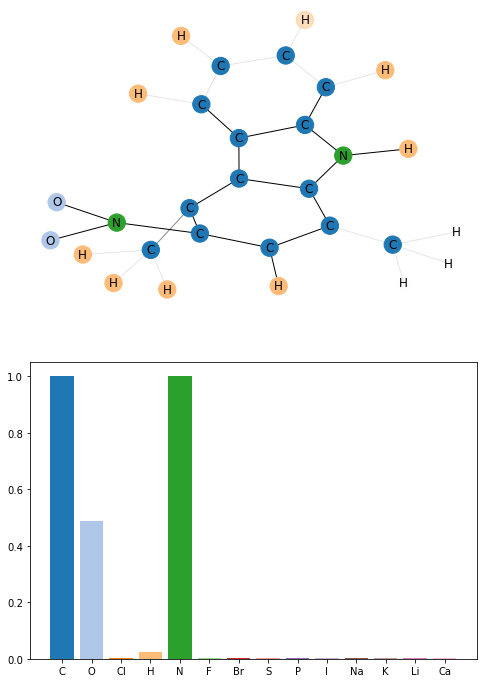

In [17]:
explainer.explain(get_tensor_representation([val_graphs[instance_index]]), output_to_explain=tf.Variable([0.]))
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)